In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [11]:
data_lst = []
y_lst = []
for type in ['point', 'pattern']:
    df = pd.read_csv(f'data_processed/synthetic_{type}.csv', index_col=0)
    split = int(0.4*df.shape[0])
    train_df = df.iloc[: split]
    test_df = df.iloc[split: ]
    label01 = df['label01'].values[split:]
    labelmul = df['labelmul'].values[split:]
    df = df.drop(['label01', 'labelmul'], axis=1)

    y = label01
    data = test_df.values[:, 0]

    if type == 'pattern':
        anom_pairs = []
        if y is not None:
            anom_index = np.where(y == 1)[0]
            tmp_seg = []
            for i in anom_index:
                tmp_seg.append(i)
                if i + 1 not in anom_index:
                    anom_pairs.append((tmp_seg[0], tmp_seg[-1]))
                    tmp_seg = []
    
    data_lst.append(data)
    y_lst.append(y)

In [12]:
path = '@results_showcase/'
algo_lst = ['couta']
algo_lst = algo_lst[::-1]
n_algo = len(algo_lst)

In [13]:

left = 50
right = 500


score_df_lst = []
for type in ['point', 'pattern']:
    score_df = pd.DataFrame()
    for algo in algo_lst:
        # print(algo)
        try:
            score = np.load(path + f'showcase_{type}_score_{algo}.npy', allow_pickle=True)
            score_ = score[left:right]
            score = (score - np.min(score_)) / (np.max(score_) - np.min(score_))
        except FileNotFoundError:
            score = np.zeros(len(y))
            print(type, algo, 'missing')
        score_df[algo] = score
    index = np.arange(len(score))
    score_df['index'] = index
    
    score_df['COUTA (ours)'] = score_df['couta']
    score_df = score_df.drop('couta', axis=1)
    
    score_df_lst.append(score_df)

In [14]:
score_df

,index,COUTA (ours)
0,0,-0.000128
1,1,-0.000128
2,2,-0.000128
3,3,-0.000128
4,4,-0.000128
...,...,...
595,595,0.000136
596,596,0.000396
597,597,0.000464
598,598,0.000173


In [15]:
algo_lst = ['COUTA (ours)']

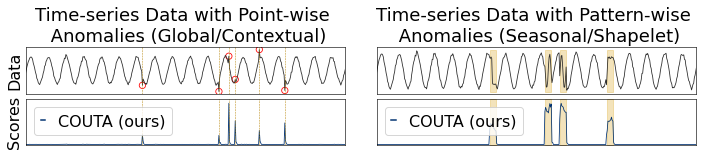

In [17]:
fig = plt.figure(figsize=(12, 1.8*n_algo))

for ii, (y, data, score_df) in enumerate(zip(y_lst, data_lst, score_df_lst)):
    fig.add_subplot(n_algo+1, 2, 1+ii)
    index = score_df['index']
    sns.lineplot(x=index, y=data, linewidth=0.8, color=sns.color_palette('Greys_r')[0])
    
    if ii == 0:
        plt.scatter(np.where(y==1)[0], data[np.where(y==1)[0]], color='none', marker='o', linewidth=0.8,
                    alpha=1, edgecolors='r', s=40)
        for idx in np.where(y==1)[0]:
            plt.axvline(idx, color='darkgoldenrod', alpha=1, linewidth=0.5,  linestyle='--')
    else:
        value_min = np.around(data.min(), decimals=1) - 0.1;value_max = np.around(data.max(), decimals=1) + 0.1
        values_ = np.linspace(value_min, value_max, 10)
        for pair in anom_pairs:
            x1 = np.ones(len(values_)) * pair[0];x2 = np.ones(len(values_)) * pair[1]
            plt.fill_betweenx(values_, x1, x2, alpha=0.3, color='goldenrod')

    ax = plt.gca()
    for loc in ['bottom', 'left', 'top', 'right']:
        ax.spines[loc].set_linewidth(0.6)

     
    plt.xlim(left, right)
    plt.xlabel('')
    plt.ylabel('Data' if ii == 0 else '', fontsize=16)
    plt.xticks([])
    plt.yticks([])
    plt.title('Time-series Data with Point-wise \n Anomalies (Global/Contextual)' if ii ==0 else 'Time-series Data with Pattern-wise \n Anomalies (Seasonal/Shapelet)', fontsize=18)

    for jj, algo in enumerate(algo_lst):
        
        ax=fig.add_subplot(n_algo+1, 2, 3+ii+jj*2)
        # palette = sns.color_palette("bone", 6)

        score_df['name'] = algo
        sns.lineplot(x='index', y=algo, data=score_df, hue='name', legend=True, 
                     linewidth=0.8, 
                     # palette=sns.color_palette("ocean", 1)
                     palette=sns.color_palette("cividis", 10)[:1]
                    )
        plt.legend(loc='upper left', ncol=1, fontsize=16, handlelength=0.3)
        if ii == 0:   
            for idx in np.where(y==1)[0]:
                plt.axvline(idx, color='darkgoldenrod', alpha=1, linewidth=0.5, linestyle='--')
        else:
            values_ = np.linspace(-0.02, 1.1, 10)
            for pair in anom_pairs:
                plt.fill_betweenx(values_, np.ones(len(values_))*pair[0], np.ones(len(values_))*pair[1], alpha=0.3, 
                                  # color='red'
                                  color='goldenrod'
                                 )

        plt.xlim(left, right)
        plt.ylim(-0.02, 1.1)
        plt.xlabel('')
        plt.ylabel('Scores' if ii == 0 else '', fontsize=16)
        plt.xticks([])
        plt.yticks([])
        
        ax = plt.gca()
        for loc in ['bottom', 'left', 'top', 'right']:
            ax.spines[loc].set_linewidth(0.6)


plt.subplots_adjust(wspace=0.1, hspace=0.12)
# plt.savefig(f'showcase.pdf', bbox_inches = 'tight')